In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import datetime
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc as sklearn_auc


# Setup logging
logging.basicConfig(filename='model_training.log', level=logging.INFO)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

# Preprocessing and Tokenization
def preprocess_data(data):
    data['text'] = data['text'].apply(lambda x: x.lower())
    data['text'] = data['text'].str.replace('[^a-zA-Z\s]', '', regex=True)
    data['text'] = data['text'].str.replace(r'\s+', ' ', regex=True)
    return data

def tokenize_reviews(tokenizer, texts):
    return tokenizer(texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')


In [4]:

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }


In [5]:

# Regularization
def apply_regularization(model):
    for param in model.parameters():
        param.requires_grad = True
    return model


In [6]:

# Training function
def train_model(model, train_loader, optimizer, scheduler, criterion, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")


In [7]:

# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred_prob = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

            y_true.extend(labels)
            y_pred_prob.extend(predictions)

    return np.array(y_true), np.array(y_pred_prob)




In [8]:
# Evaluation Metrics
def log_metrics(metrics):
    logging.info(metrics)

def print_metrics(y_true, y_pred_prob):
    if len(np.unique(y_true)) < 2:
        print("Only one class present in y_true. Skipping metrics calculation for this fold.")
        return

    accuracy = accuracy_score(y_true, y_pred_prob)
    precision = precision_score(y_true, y_pred_prob, zero_division=1)
    recall = recall_score(y_true, y_pred_prob, zero_division=1)
    f1 = f1_score(y_true, y_pred_prob, zero_division=1)
    auc_score = roc_auc_score(y_true, y_pred_prob)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score
    }
    log_metrics(metrics)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc_score}")

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = sklearn_auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot confusion matrix
    plot_confusion_matrix(confusion_matrix(y_true, y_pred_prob))

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')
    plt.show()


In [9]:
# Model Saving and Loading
def save_model(model, model_name='bert_model.pth'):
    torch.save(model.state_dict(), model_name)
    print(f"Model saved to {model_name}")

def load_model(model_class, model_name='bert_model.pth'):
    model = model_class.from_pretrained('bert-base-uncased')
    model.load_state_dict(torch.load(model_name))
    return model



In [10]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [11]:
# Load and preprocess data
df = pd.read_csv('/content/drive/MyDrive/5000human_5000machine.csv', encoding='latin1')
df = preprocess_data(df)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Prepare data for cross-validation
X = df['text']
y = df['label']



In [13]:
# Standalone training and evaluation
def standalone_training_and_evaluation(X, y, tokenizer, model, num_epochs=10):
    # Split the data into train and test sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Tokenize the data
    train_encodings = tokenize_reviews(tokenizer, X_train)
    test_encodings = tokenize_reviews(tokenizer, X_test)

    # Create Datasets
    train_dataset = CustomDataset(
        train_encodings['input_ids'],
        train_encodings['attention_mask'],
        torch.tensor(y_train.values, dtype=torch.long)
    )
    test_dataset = CustomDataset(
        test_encodings['input_ids'],
        test_encodings['attention_mask'],
        torch.tensor(y_test.values, dtype=torch.long)
    )

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Define optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    criterion = torch.nn.CrossEntropyLoss()

    # Train the model
    train_model(model, train_loader, optimizer, scheduler, criterion, num_epochs, device)

    # Evaluate the model
    y_true, y_pred_prob = evaluate_model(model, test_loader, device)
    print("Standalone Training and Evaluation Results:")
    print_metrics(y_true, y_pred_prob)

    # Save the model
    save_model(model, 'standalone_bert_model.pth')



In [ ]:
#standalone_training_and_evaluation(X, y, tokenizer, model)



In [14]:
# Cross-validation
def cross_validation_training(X, y, tokenizer, model_class, n_splits=5, num_epochs=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold = 1

    for train_index, test_index in kf.split(X):
        print(f"Training fold {fold}...")

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Tokenize the data
        train_encodings = tokenize_reviews(tokenizer, X_train)
        test_encodings = tokenize_reviews(tokenizer, X_test)

        # Create Datasets
        train_dataset = CustomDataset(
            train_encodings['input_ids'],
            train_encodings['attention_mask'],
            torch.tensor(y_train.values, dtype=torch.long)
        )
        test_dataset = CustomDataset(
            test_encodings['input_ids'],
            test_encodings['attention_mask'],
            torch.tensor(y_test.values, dtype=torch.long)
        )

        # Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32)

        # Define model, optimizer, and scheduler
        model = model_class.from_pretrained('bert-base-uncased', num_labels=2)
        model = apply_regularization(model).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
        total_steps = len(train_loader) * num_epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
        criterion = torch.nn.CrossEntropyLoss()

        # Train the model
        train_model(model, train_loader, optimizer, scheduler, criterion, num_epochs, device)

        # Evaluate the model
        y_true, y_pred_prob = evaluate_model(model, test_loader, device)
        print(f"Results for fold {fold}:")
        print_metrics(y_true, y_pred_prob)

        fold += 1

        # Save the model
        save_model(model, f'bert_model_fold_{fold}.pth')



Training fold 1...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Loss: 0.2255
Epoch 2/10, Loss: 0.0610
Epoch 3/10, Loss: 0.0221
Epoch 4/10, Loss: 0.0086
Epoch 5/10, Loss: 0.0037
Epoch 6/10, Loss: 0.0012
Epoch 7/10, Loss: 0.0004
Epoch 8/10, Loss: 0.0007
Epoch 9/10, Loss: 0.0003
Epoch 10/10, Loss: 0.0002
Results for fold 1:
Accuracy: 0.9635
Precision: 0.9420289855072463
Recall: 0.9868421052631579
F1 Score: 0.9639149777558083
AUC: 0.9637767838568754


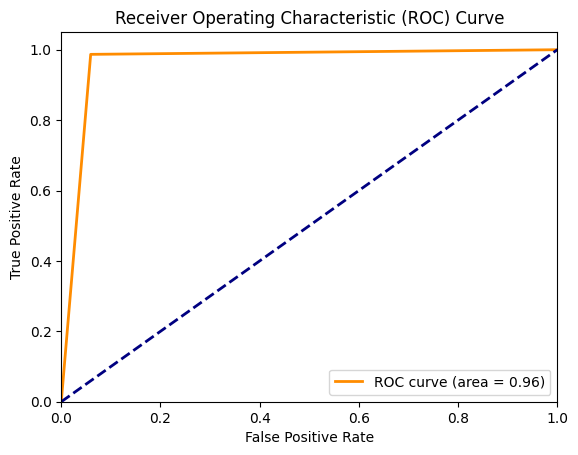

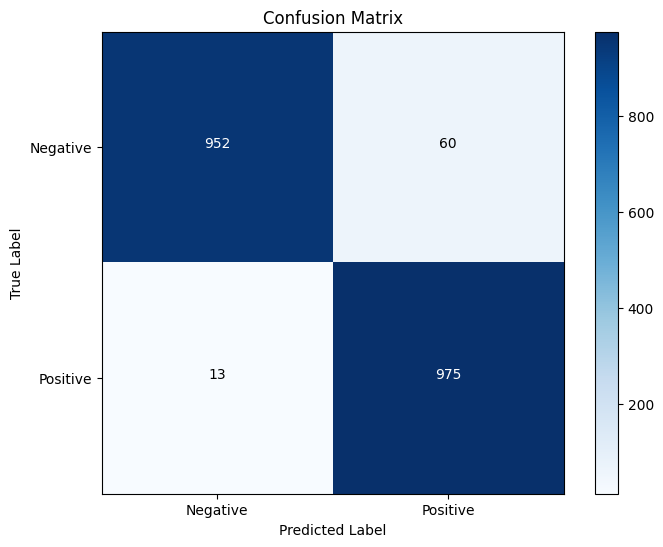

Model saved to bert_model_fold_2.pth
Training fold 2...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Loss: 0.2288
Epoch 2/10, Loss: 0.0542
Epoch 3/10, Loss: 0.0190
Epoch 4/10, Loss: 0.0058
Epoch 5/10, Loss: 0.0011
Epoch 6/10, Loss: 0.0004
Epoch 7/10, Loss: 0.0009
Epoch 8/10, Loss: 0.0006
Epoch 9/10, Loss: 0.0005
Epoch 10/10, Loss: 0.0002
Results for fold 2:
Accuracy: 0.968
Precision: 0.9432270916334662
Recall: 0.9926624737945493
F1 Score: 0.9673135852911133
AUC: 0.9690845829775806


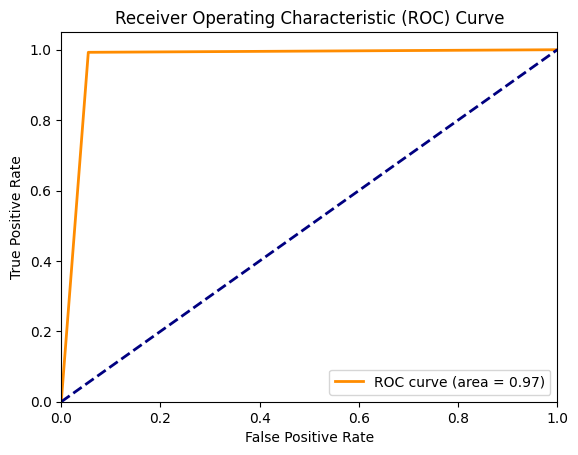

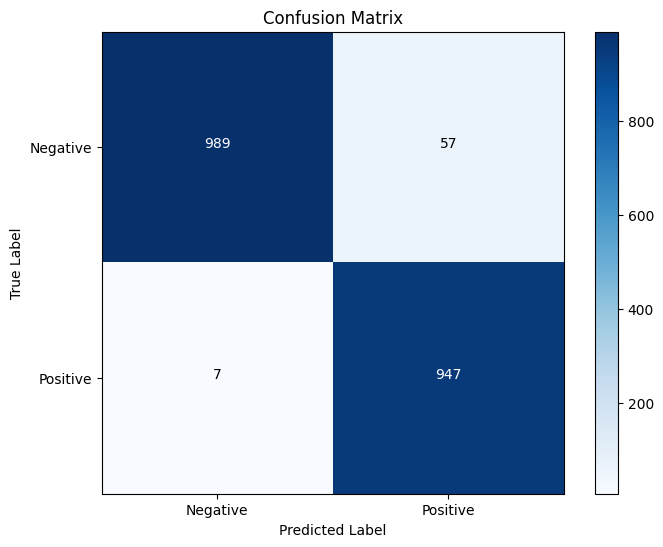

Model saved to bert_model_fold_3.pth
Training fold 3...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Loss: 0.2385
Epoch 2/10, Loss: 0.0587
Epoch 3/10, Loss: 0.0163
Epoch 4/10, Loss: 0.0068
Epoch 5/10, Loss: 0.0064
Epoch 6/10, Loss: 0.0021
Epoch 7/10, Loss: 0.0035
Epoch 8/10, Loss: 0.0006
Epoch 9/10, Loss: 0.0003
Epoch 10/10, Loss: 0.0002
Results for fold 3:
Accuracy: 0.9685
Precision: 0.9430199430199431
Recall: 0.9969879518072289
F1 Score: 0.9692532942898975
AUC: 0.9686134978159651


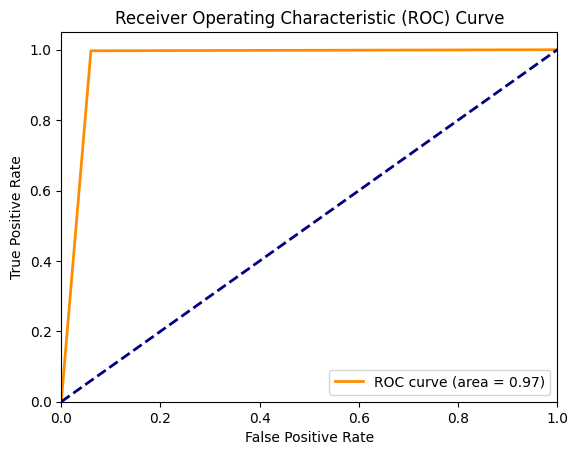

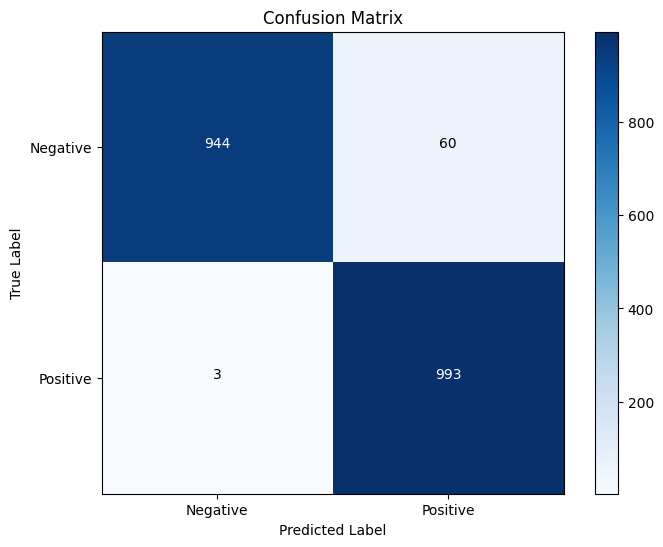

Model saved to bert_model_fold_4.pth
Training fold 4...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Loss: 0.2311
Epoch 2/10, Loss: 0.0566
Epoch 3/10, Loss: 0.0216
Epoch 4/10, Loss: 0.0086
Epoch 5/10, Loss: 0.0063
Epoch 6/10, Loss: 0.0046
Epoch 7/10, Loss: 0.0013
Epoch 8/10, Loss: 0.0008
Epoch 9/10, Loss: 0.0010
Epoch 10/10, Loss: 0.0005
Results for fold 4:
Accuracy: 0.9505
Precision: 0.9191111111111111
Recall: 0.9923224568138196
F1 Score: 0.9543147208121827
AUC: 0.9486664476135903


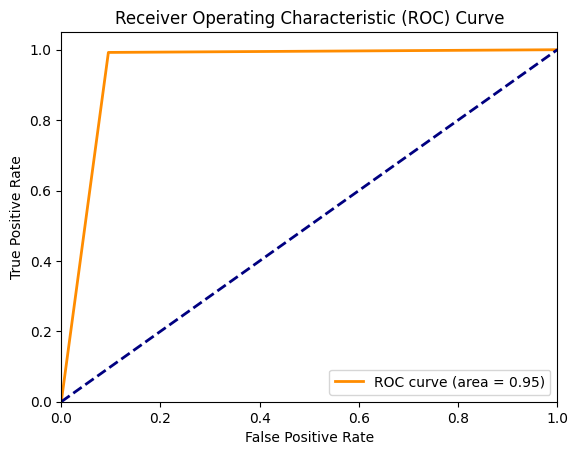

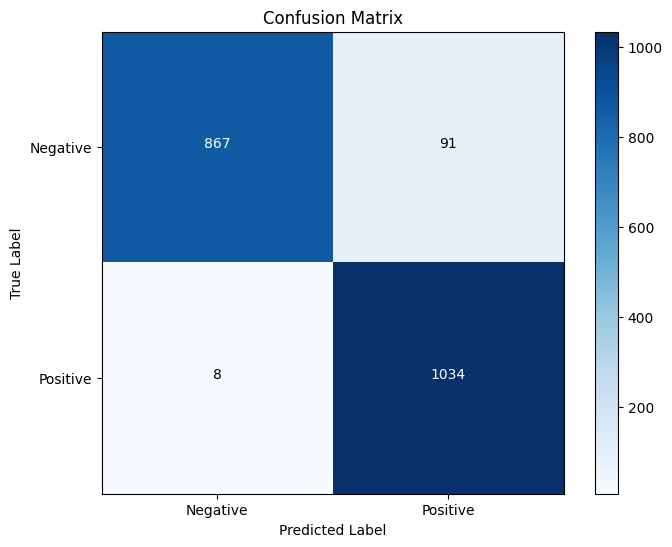

Model saved to bert_model_fold_5.pth
Training fold 5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Loss: 0.2298
Epoch 2/10, Loss: 0.0575
Epoch 3/10, Loss: 0.0238
Epoch 4/10, Loss: 0.0056
Epoch 5/10, Loss: 0.0052
Epoch 6/10, Loss: 0.0009
Epoch 7/10, Loss: 0.0004
Epoch 8/10, Loss: 0.0003
Epoch 9/10, Loss: 0.0003
Epoch 10/10, Loss: 0.0003
Results for fold 5:
Accuracy: 0.956
Precision: 0.9275229357798165
Recall: 0.9911764705882353
F1 Score: 0.9582938388625593
AUC: 0.9552821128451381


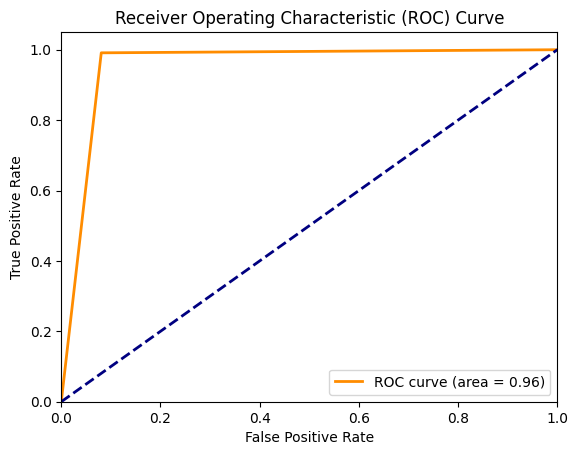

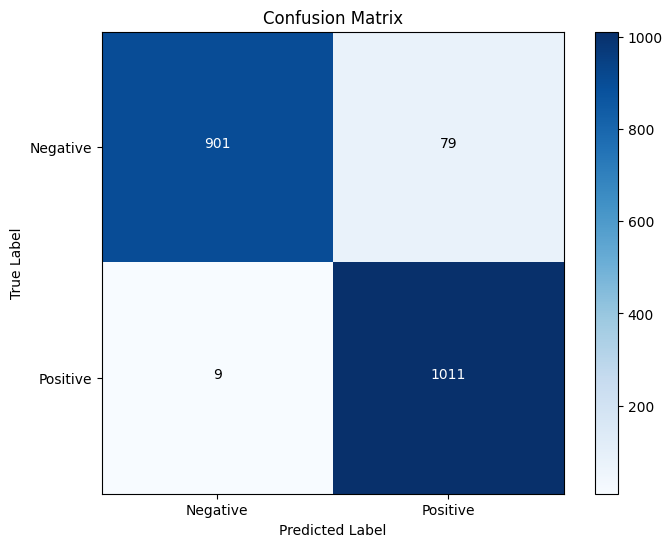

Model saved to bert_model_fold_6.pth


In [15]:
cross_validation_training(X, y, tokenizer, BertForSequenceClassification)
